# Geodésicas
Se buscará obtener las geodésicas y baricentros de la misma forma que en el ejemplo [Convolutional Wasserstein Barycenter](https://pythonot.github.io/auto_examples/barycenters/plot_convolutional_barycenter.html#sphx-glr-auto-examples-barycenters-plot-convolutional-barycenter-py), para luego obtener geodésicas implementadas en esta librería.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import ot
import torch
from PIL import Image
# noinspection PyUnresolvedReferences
from PIL.Image import Resampling

# noinspection PyProtectedMember
from bwb import _logging
from bwb import transports as trnsp
from bwb.distributions import *
from bwb.geodesics import *

_log = _logging.get_logger(__name__)
_logging.set_level(_logging.DEBUG)
_log

In [2]:
main_path = Path("..")

data_path = main_path / "data"
data_images_path = data_path / "images"
shapes_path = data_images_path / "shapes"
pot_shapes_path = data_images_path / "pot_shapes"

img_path = Path("img")

In [3]:
resolution = 128
size = (resolution, resolution)
resample = Resampling.LANCZOS

In [4]:
# # noinspection PyTypeChecker
# f1 = 1 - np.asarray(Image.open(pot_shapes_path / 'redcross.png').resize(size, resample))[:, :, 2] / 255
# # noinspection PyTypeChecker
# f2 = 1 - np.asarray(Image.open(pot_shapes_path / 'tooth.png').resize(size, resample))[:, :, 2] / 255
# # noinspection PyTypeChecker
# f3 = 1 - np.asarray(Image.open(pot_shapes_path / 'heart.png').resize(size, resample))[:, :, 2] / 255
# # noinspection PyTypeChecker
# f4 = 1 - np.asarray(Image.open(pot_shapes_path / 'duck.png').resize(size, resample))[:, :, 2] / 255

In [5]:
# noinspection PyTypeChecker
f1 = 1 - np.asarray(Image.open(shapes_path / 'shape1filled.png').resize(size, resample))[:, :, 2] / 255
# noinspection PyTypeChecker
f2 = 1 - np.asarray(Image.open(shapes_path / 'shape2filled.png').resize(size, resample))[:, :, 2] / 255
# noinspection PyTypeChecker
f3 = 1 - np.asarray(Image.open(shapes_path / 'shape3filled.png').resize(size, resample))[:, :, 2] / 255
# noinspection PyTypeChecker
f4 = 1 - np.asarray(Image.open(shapes_path / 'shape4filled.png').resize(size, resample))[:, :, 2] / 255

In [6]:
f1 = f1 / np.sum(f1)
f2 = f2 / np.sum(f2)
f3 = f3 / np.sum(f3)
f4 = f4 / np.sum(f4)
A = np.array([f1, f2, f3, f4])

nb_images = 5

# those are the four corners coordinates that will be interpolated by bilinear
# interpolation
v1 = np.array((1, 0, 0, 0))
v2 = np.array((0, 1, 0, 0))
v3 = np.array((0, 0, 1, 0))
v4 = np.array((0, 0, 0, 1))

In [7]:
additional_info = f"resol-{resolution}-nb-images-{nb_images}"

2023-05-06 19:34:46,160: DEBUG [__main__:38]
> i = 0, j = 0 ==> Total time: 0.0010 [seg]
2023-05-06 19:34:49,422: DEBUG [__main__:38]
> i = 0, j = 1 ==> Total time: 3.2592 [seg]


KeyboardInterrupt: 

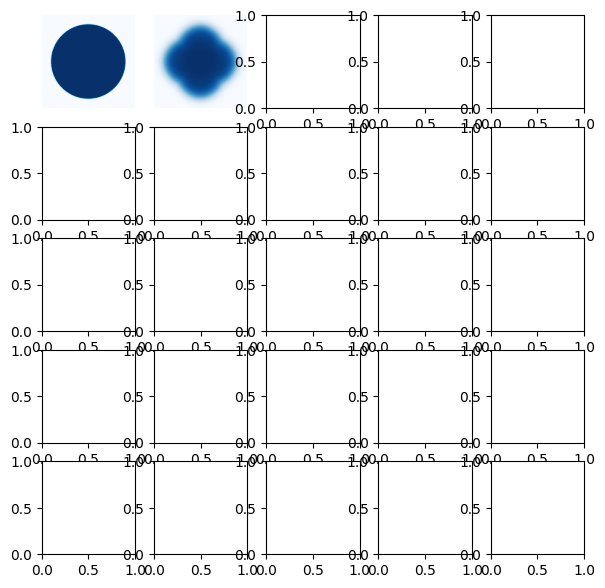

In [8]:
%%time
import time

fig, axes = plt.subplots(nb_images, nb_images, figsize=(7, 7))
cm = 'Blues'
# regularization parameter
reg = 4e-3
# reg = 2e-3
tic_ = time.time()
for i in range(nb_images):
    for j in range(nb_images):
        tic = time.time()

        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)

        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        weights = (1 - ty) * tmp1 + ty * tmp2

        if i == 0 and j == 0:
            axes[i, j].imshow(f1, cmap=cm)
        elif i == 0 and j == (nb_images - 1):
            axes[i, j].imshow(f3, cmap=cm)
        elif i == (nb_images - 1) and j == 0:
            axes[i, j].imshow(f2, cmap=cm)
        elif i == (nb_images - 1) and j == (nb_images - 1):
            axes[i, j].imshow(f4, cmap=cm)
        else:
            # call to barycenter computation
            axes[i, j].imshow(
                ot.bregman.convolutional_barycenter2d(A, reg, weights),
                cmap=cm
            )
        axes[i, j].axis('off')

        toc = time.time()
        _log.debug(f"{i = }, {j = } ==> Total time: {toc - tic:.4f} [seg]")
toc_ = time.time()
d_time = f"\nΔt={toc_-tic_:.1f}[seg]"

plt.suptitle(f'Convolutional Wasserstein Barycenters in POT. {d_time}')

plt.tight_layout()
plt.savefig(img_path / f"{additional_info}-conv-wasserstein-bar.png", dpi=400)
plt.show()

# Utilizando geodésicas
Ahora que tenemos los resultados replicados del notebook de ejemplo, se procederá a replicar los resultados utilizando las clases creadas en esta librería, sólo calculando las geodésicas de par a par.

In [9]:
original_shape = f1.shape

dd1 = DistributionDraw.from_weights(f1.reshape(-1), original_shape)
dd2 = DistributionDraw.from_weights(f2.reshape(-1), original_shape)
dd3 = DistributionDraw.from_weights(f3.reshape(-1), original_shape)
dd4 = DistributionDraw.from_weights(f4.reshape(-1), original_shape)

Ahora se realizarán las matrices que serán graficadas

In [10]:
%%time
geodesic12 = McCannGeodesic(trnsp.EMDTransport(max_iter=250_000)).fit(dd_s=dd1, dd_t=dd2)
geodesic13 = McCannGeodesic(trnsp.EMDTransport(max_iter=250_000)).fit(dd_s=dd1, dd_t=dd3)
geodesic34 = McCannGeodesic(trnsp.EMDTransport(max_iter=250_000)).fit(dd_s=dd3, dd_t=dd4)
geodesic24 = McCannGeodesic(trnsp.EMDTransport(max_iter=250_000)).fit(dd_s=dd2, dd_t=dd4)

2023-05-06 19:34:53,825: DEBUG [bwb._protocols:56]
> Fitting with distribution from the FitWithDistribution Protocol.
2023-05-06 19:34:53,856: DEBUG [bwb.geodesics:38]
> Fitting with measure from the BaseGeodesic class.
2023-05-06 19:34:53,858: DEBUG [bwb.transports:96]
> Adjusting with a measure from the EMDTransport class
2023-05-06 19:34:53,859: DEBUG [bwb.transports:97]
> Shapes: Xs.shape=torch.Size([8804, 2]), Xt.shape=torch.Size([2486, 2])
2023-05-06 19:35:08,064: DEBUG [bwb.transports:158]
> The function 'fit_wm' takes 14.2059 [seg]
2023-05-06 19:35:08,068: DEBUG [bwb.geodesics:59]
> Using the method _fit.
2023-05-06 19:35:08,070: DEBUG [bwb.geodesics:61]
> n=8804, dim_0=2
2023-05-06 19:35:08,071: DEBUG [bwb.geodesics:63]
> m=2486, dim_1=2
2023-05-06 19:35:08,074: DEBUG [bwb.geodesics:158]
> The function 'fit_wm' takes 14.2174 [seg]
2023-05-06 19:35:08,076: DEBUG [bwb.geodesics:158]
> The function 'fit' takes 14.2507 [seg]
2023-05-06 19:35:08,078: DEBUG [bwb._protocols:56]
> Fit

CPU times: total: 53.1 s
Wall time: 50.1 s


In [11]:
M = np.arange(12).reshape((3, 4))
M[np.array([1, 0]), np.array([2, 2])]
M

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [ ]:
%%time
import time

fig, axes = plt.subplots(nb_images, nb_images, figsize=(7, 7))
cm = 'Blues'
tic_ = time.time()
for i in range(nb_images):
    for j in range(nb_images):
        tic = time.time()

        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)

        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        weights = (1 - ty) * tmp1 + ty * tmp2

        axes_ij = axes[i, j]

        if i == 0 and j == 0:
            axes_ij.imshow(f1, cmap=cm)
        elif i == 0 and j == (nb_images - 1):
            axes_ij.imshow(f3, cmap=cm)
        elif i == (nb_images - 1) and j == 0:
            axes_ij.imshow(f2, cmap=cm)
        elif i == (nb_images - 1) and j == (nb_images - 1):
            axes_ij.imshow(f4, cmap=cm)
        elif i == 0:
            dd_t = DistributionDraw(*geodesic13.interpolate(ty), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        elif i == (nb_images - 1):
            dd_t = DistributionDraw(*geodesic24.interpolate(ty), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        elif j == 0:
            dd_t = DistributionDraw(*geodesic12.interpolate(tx), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        elif j == (nb_images - 1):
            dd_t = DistributionDraw(*geodesic34.interpolate(tx), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        else:
            axes_ij.imshow(np.zeros(original_shape), cmap=cm)
        axes_ij.axis('off')

        toc = time.time()
        _log.debug(f"{i = }, {j = } ==> Total time: {toc - tic:.4f} [seg]")
toc_ = time.time()
d_time = f"\nΔt={toc_-tic_:.1f}[seg]"

plt.suptitle(f'McCann Interpolation with EMD Transport. {d_time}')

plt.tight_layout()
plt.savefig(img_path / f"{additional_info}-mccaan-interpolation-emd.png", dpi=800)
plt.show()

2023-05-06 19:35:45,139: DEBUG [__main__:45]
> i = 0, j = 0 ==> Total time: 0.0040 [seg]
2023-05-06 19:35:45,140: DEBUG [bwb.geodesics:77]
> Interpolating with t=0.25
2023-05-06 19:35:46,522: DEBUG [bwb.geodesics:80]
> X.shape = torch.Size([8804, 3490, 2])
2023-05-06 19:35:46,537: DEBUG [bwb.geodesics:82]
> coupling.shape = torch.Size([8804, 3490])
2023-05-06 19:35:52,834: DEBUG [bwb.geodesics:87]
> nz_coord[0].shape = torch.Size([11984])
2023-05-06 19:35:52,958: DEBUG [bwb.geodesics:89]
> X_to_return.shape = torch.Size([11984, 2])
2023-05-06 19:35:52,977: DEBUG [bwb.geodesics:91]
> weights.shape = torch.Size([11984])
2023-05-06 19:35:53,023: DEBUG [bwb.geodesics:92]
> weights.sum() = 0.9998
2023-05-06 19:35:53,127: DEBUG [bwb.geodesics:158]
> The function 'interpolate' takes 7.9861 [seg]
2023-05-06 19:35:57,494: DEBUG [bwb._logging:158]
> The function 'grayscale' takes 4.2647 [seg]
2023-05-06 19:35:57,557: DEBUG [__main__:45]
> i = 0, j = 1 ==> Total time: 12.4175 [seg]
2023-05-06 19:

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000018F15596710> (for post_execute):


# Interpolación con la proyección baricéntrica

In [13]:
%%time
geodesic12 = BarycentricProjGeodesic(trnsp.EMDTransport(max_iter=250_000)).fit(dd_s=dd1, dd_t=dd2)
geodesic13 = BarycentricProjGeodesic(trnsp.EMDTransport(max_iter=250_000)).fit(dd_s=dd1, dd_t=dd3)
geodesic34 = BarycentricProjGeodesic(trnsp.EMDTransport(max_iter=250_000)).fit(dd_s=dd3, dd_t=dd4)
geodesic24 = BarycentricProjGeodesic(trnsp.EMDTransport(max_iter=250_000)).fit(dd_s=dd2, dd_t=dd4)

2023-05-06 19:36:01,993: DEBUG [bwb._protocols:56]
> Fitting with distribution from the FitWithDistribution Protocol.
2023-05-06 19:36:02,014: DEBUG [bwb.geodesics:38]
> Fitting with measure from the BaseGeodesic class.
2023-05-06 19:36:02,015: DEBUG [bwb.transports:96]
> Adjusting with a measure from the EMDTransport class
2023-05-06 19:36:02,016: DEBUG [bwb.transports:97]
> Shapes: Xs.shape=torch.Size([8804, 2]), Xt.shape=torch.Size([2486, 2])

KeyboardInterrupt




KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x0000018F7BF104C0> (for post_execute):


KeyboardInterrupt: 

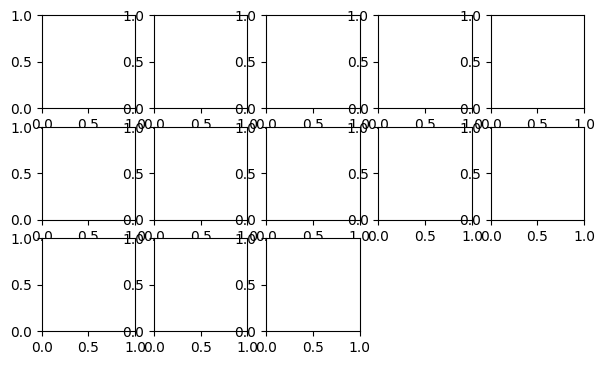

In [14]:
%%time
import time

fig, axes = plt.subplots(nb_images, nb_images, figsize=(7, 7))
cm = 'Blues'
tic_ = time.time()
for i in range(nb_images):
    for j in range(nb_images):
        tic = time.time()

        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)

        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        weights = (1 - ty) * tmp1 + ty * tmp2

        axes_ij = axes[i, j]

        if i == 0 and j == 0:
            axes_ij.imshow(f1, cmap=cm)
        elif i == 0 and j == (nb_images - 1):
            axes_ij.imshow(f3, cmap=cm)
        elif i == (nb_images - 1) and j == 0:
            axes_ij.imshow(f2, cmap=cm)
        elif i == (nb_images - 1) and j == (nb_images - 1):
            axes_ij.imshow(f4, cmap=cm)
        elif i == 0:
            dd_t = DistributionDraw(*geodesic13.interpolate(ty), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        elif i == (nb_images - 1):
            dd_t = DistributionDraw(*geodesic24.interpolate(ty), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        elif j == 0:
            dd_t = DistributionDraw(*geodesic12.interpolate(tx), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        elif j == (nb_images - 1):
            dd_t = DistributionDraw(*geodesic34.interpolate(tx), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        else:
            axes_ij.imshow(np.zeros(original_shape), cmap=cm)
        axes_ij.axis('off')

        toc = time.time()
        _log.debug(f"{i = }, {j = } ==> Total time: {toc - tic:.4f} [seg]")
toc_ = time.time()
d_time = f"\nΔt={toc_-tic_:.1f}[seg]"
plt.suptitle(f'Barycentric Projection Interpolation with EMD Transport. {d_time}')
plt.tight_layout()
plt.savefig(img_path / f"{additional_info}-barycentric-proj-interpolation-emd.png", dpi=800)
plt.show()

# Interpolación con Sinkhorn

2023-05-06 19:36:06,353: DEBUG [bwb._logging:158]
> The function 'grayscale' takes 0.0011 [seg]


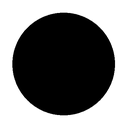

In [15]:
dd1

2023-05-06 19:36:06,380: DEBUG [bwb._logging:158]
> The function 'grayscale' takes 0.0007 [seg]


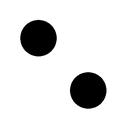

In [16]:
dd2

In [17]:
%%time
kwargs = {
    "max_iter": 250_000,
    "reg_e": 1e-3,
    "verbose": True,
    "norm": "max"
}

CPU times: total: 0 ns
Wall time: 0 ns


In [18]:
%%time
geodesic12 = McCannGeodesic(trnsp.SinkhornTransport(**kwargs)).fit(dd_s=dd1, dd_t=dd2)

2023-05-06 19:36:06,427: DEBUG [bwb._protocols:56]
> Fitting with distribution from the FitWithDistribution Protocol.
2023-05-06 19:36:06,432: DEBUG [bwb.geodesics:38]
> Fitting with measure from the BaseGeodesic class.
2023-05-06 19:36:06,434: DEBUG [bwb.transports:40]
> Adjusting with a measure from the SinkhornTransport class


It.  |Err         
-------------------
    0|5.665597e-02|
   10|1.606199e-02|
   20|9.323817e-03|
   30|6.024416e-03|
   40|4.005877e-03|
   50|2.684535e-03|
   60|1.802216e-03|
   70|1.209978e-03|
   80|8.121508e-04|
   90|5.450455e-04|
  100|3.658346e-04|
  110|2.456705e-04|
  120|1.651385e-04|
  130|1.111895e-04|
  140|7.506432e-05|
  150|5.088927e-05|
  160|3.472925e-05|
  170|2.394955e-05|
  180|1.678615e-05|
  190|1.205587e-05|
It.  |Err         
-------------------
  200|8.960266e-06|
  210|6.953955e-06|
  220|5.659674e-06|
  230|4.817226e-06|
  240|4.252602e-06|
  250|3.855196e-06|
  260|3.558152e-06|
  270|3.322411e-06|
  280|3.125459e-06|
  290|2.954249e-06|
  300|2.801075e-06|
  310|2.661257e-06|
  320|2.531857e-06|
  330|2.410961e-06|
  340|2.297276e-06|
  350|2.189896e-06|
  360|2.088157e-06|
  370|1.991558e-06|
  380|1.899700e-06|
  390|1.812261e-06|
It.  |Err         
-------------------
  400|1.728968e-06|
  410|1.649584e-06|
  420|1.573898e-06|
  430|1.501720e-06|
  4

KeyboardInterrupt: 

In [19]:
geodesic12.transport.cost_

tensor([[  490.,   449.,   410.,  ..., 11156., 11225., 11296.],
        [  533.,   490.,   449.,  ..., 11089., 11156., 11225.],
        [  578.,   533.,   490.,  ..., 11024., 11089., 11156.],
        ...,
        [11024., 10961., 10900.,  ...,   578.,   625.,   674.],
        [11089., 11024., 10961.,  ...,   533.,   578.,   625.],
        [11156., 11089., 11024.,  ...,   490.,   533.,   578.]],
       dtype=torch.float64)

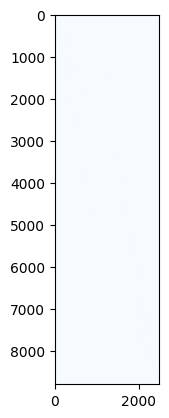

In [20]:
plt.imshow(geodesic12.transport.coupling_, cmap=cm)

2023-05-06 19:36:48,450: DEBUG [bwb.geodesics:77]
> Interpolating with t=0.50
2023-05-06 19:36:48,725: DEBUG [bwb.geodesics:80]
> X.shape = torch.Size([8804, 2486, 2])
2023-05-06 19:36:48,728: DEBUG [bwb.geodesics:82]
> coupling.shape = torch.Size([8804, 2486])
2023-05-06 19:36:51,183: DEBUG [bwb.geodesics:87]
> nz_coord[0].shape = torch.Size([11005])
2023-05-06 19:36:51,198: DEBUG [bwb.geodesics:89]
> X_to_return.shape = torch.Size([11005, 2])
2023-05-06 19:36:51,203: DEBUG [bwb.geodesics:91]
> weights.shape = torch.Size([11005])
2023-05-06 19:36:51,212: DEBUG [bwb.geodesics:92]
> weights.sum() = 0.9998
2023-05-06 19:36:51,277: DEBUG [bwb.geodesics:158]
> The function 'interpolate' takes 2.8278 [seg]
2023-05-06 19:36:51,315: DEBUG [bwb._logging:158]
> The function 'grayscale' takes 0.0069 [seg]


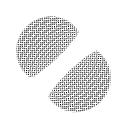

In [21]:
interp_param = {}
# interp_param = {
#     "rtol": ,
#     "atol": 0,
# }

DistributionDraw(*geodesic12.interpolate(0.5, **interp_param), original_shape)

In [22]:
%%time
geodesic13 = McCannGeodesic(trnsp.SinkhornTransport(**kwargs)).fit(dd_s=dd1, dd_t=dd3)

2023-05-06 19:36:51,351: DEBUG [bwb._protocols:56]
> Fitting with distribution from the FitWithDistribution Protocol.
2023-05-06 19:36:51,367: DEBUG [bwb.geodesics:38]
> Fitting with measure from the BaseGeodesic class.
2023-05-06 19:36:51,369: DEBUG [bwb.transports:40]
> Adjusting with a measure from the SinkhornTransport class


It.  |Err         
-------------------
    0|2.349616e-02|
   10|6.916419e-03|
   20|4.554454e-03|
   30|3.037762e-03|
   40|2.026787e-03|
   50|1.359416e-03|
   60|9.229293e-04|
   70|6.400583e-04|
   80|4.584143e-04|
   90|3.424355e-04|
  100|2.679479e-04|
  110|2.188059e-04|



KeyboardInterrupt



In [23]:
%%time
geodesic34 = McCannGeodesic(trnsp.SinkhornTransport(**kwargs)).fit(dd_s=dd3, dd_t=dd4)

2023-05-06 19:37:03,411: DEBUG [bwb._protocols:56]
> Fitting with distribution from the FitWithDistribution Protocol.

KeyboardInterrupt



In [24]:
%%time
geodesic24 = McCannGeodesic(trnsp.SinkhornTransport(**kwargs)).fit(dd_s=dd2, dd_t=dd4)

2023-05-06 19:37:03,765: DEBUG [bwb._protocols:56]
> Fitting with distribution from the FitWithDistribution Protocol.

KeyboardInterrupt



In [25]:
%%time
import time



fig, axes = plt.subplots(nb_images, nb_images, figsize=(7, 7))
cm = 'Blues'
tic_ = time.time()
for i in range(nb_images):
    for j in range(nb_images):
        tic = time.time()

        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)

        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        weights = (1 - ty) * tmp1 + ty * tmp2

        axes_ij = axes[i, j]

        if i == 0 and j == 0:
            axes_ij.imshow(f1, cmap=cm)
        elif i == 0 and j == (nb_images - 1):
            axes_ij.imshow(f3, cmap=cm)
        elif i == (nb_images - 1) and j == 0:
            axes_ij.imshow(f2, cmap=cm)
        elif i == (nb_images - 1) and j == (nb_images - 1):
            axes_ij.imshow(f4, cmap=cm)
        elif i == 0:
            dd_t = DistributionDraw(*geodesic13.interpolate(ty, **interp_param), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        elif i == (nb_images - 1):
            dd_t = DistributionDraw(*geodesic24.interpolate(ty, **interp_param), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        elif j == 0:
            dd_t = DistributionDraw(*geodesic12.interpolate(tx, **interp_param), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        elif j == (nb_images - 1):
            dd_t = DistributionDraw(*geodesic34.interpolate(tx, **interp_param), original_shape)
            axes_ij.imshow(dd_t.grayscale, cmap=cm)
        else:
            axes_ij.imshow(np.zeros(original_shape), cmap=cm)
        axes_ij.axis('off')

        toc = time.time()
        _log.debug(f"{i = }, {j = } ==> Total time: {toc - tic:.4f} [seg]")
toc_ = time.time()
d_time = f"\nΔt={toc_-tic_:.1f}[seg]"
plt.suptitle(f'McCann Interpolation with Sinkhorn Transport. {d_time}')
plt.tight_layout()
plt.savefig(img_path / f"{additional_info}-mccaan-interpolation-sinkhorn.png", dpi=800)
plt.show()

KeyboardInterrupt: 

<Figure size 700x700 with 0 Axes>